<a href="https://colab.research.google.com/github/KamonohashiPerry/MachineLearning/blob/master/deep-learning-from-scratch-2/Chapter6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ゲート付きRNN
+ 単純なRNNでは時系列データの長期の依存関係をうまく学習することはできない。

## RNNの問題点
+ BPTTにおいて勾配消失もしくは勾配爆発問題が起こることに原因がある。
 + ようは、長い時点をさかのぼっての、誤差逆伝播法がうまくいかないということ。

### RNNの復習
+ RNNレイヤは時系列データである\\(x_t\\)を入力すると\\( h_t\\)を出力する。この\\( h_t\\)はRNNレイヤの隠れ状態とも呼ばれ、過去からの情報が記憶される。
+ RNNレイヤの順伝播で行う計算は、「行列の積と和、そして活性化関数であるtanh関数による変換」から構成される。

### 勾配消失もしくは勾配爆発
+ RNNレイヤが過去方向に「意味のある勾配」を伝達することによって、時間方向の依存関係を学習することができる。
 + この勾配が途中で弱まったら、ほとんど何も情報をもたなくなったら、重みのパラメータは更新されなくなる。

### 勾配消失もしくは勾配爆発の原因
+ 逆伝播において勾配がtanhノードを通るたびに、その値はどんどん小さくなっていく。
 + tanh関数をT回通過すれば、勾配はT回も繰り返し弱められることになる。
   + ReLUを使えば勾配消失を抑えることができる。
    + 入力xが0異常であれば、逆伝播では上流の勾配をそのまま下流に流すことになり、勾配の劣化が起こらないから。 

In [0]:
import numpy as np
import matplotlib.pyplot as plt

N = 2 # バッチサイズ
H = 3 # 隠れ状態ベクトルの次元数
T = 20 # 時系列データの長さ

dh = np.ones((N, H)) # 初期化
np.random.seed(3) # 再現性のため乱数のシードを固定
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
  dh = np.dot(dh, Wh.T) # 更新
  norm = np.sqrt(np.sum(dh**2)) / N
  norm_list.append(norm)


In [3]:
norm_list

[2.4684068094579303,
 3.335704974161037,
 4.783279375373183,
 6.2795873320876145,
 8.080776465019055,
 10.25116303229294,
 12.9360635066099,
 16.276861327786712,
 20.454829618345983,
 25.688972842084684,
 32.25315718048336,
 40.48895641683869,
 50.824407307019094,
 63.79612654485427,
 80.07737014308985,
 100.51298922051251,
 126.16331847536827,
 158.3592064825883,
 198.77107967611957,
 249.495615421267]

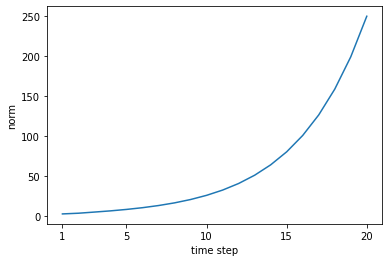

In [2]:
# グラフの描画
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

勾配の大きさは時間とともに指数関数的に増加していく。

In [0]:
dh = np.ones((N, H)) # 初期化
np.random.seed(3) # 再現性のため乱数のシードを固定
Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
  dh = np.dot(dh, Wh.T) # 更新
  norm = np.sqrt(np.sum(dh**2)) / N
  norm_list.append(norm)


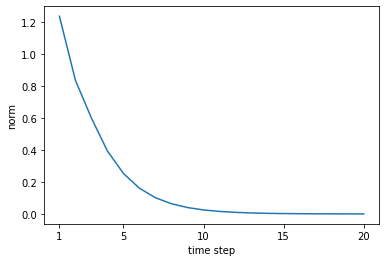

In [5]:
# グラフの描画
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

今度は勾配が指数的に減少している。

行列\\( Wh\\)をT回繰り返して乗算しているので、指数的な変化が起きてしまう。

### 勾配爆発への対策
+ 勾配クリッピング
 + 勾配のL2ノルムが閾値を超えた場合に勾配を修正する。

$$ if \ \| \hat g \| \ \geq threshold \\
\hat g = \frac{threshold}{\| \hat g \|}\hat g $$

In [0]:
import numpy as np

dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
  total_norm = 0
  for grad in grads:
    total_norm += np.sum(grad ** 2)
  total_norm = np.sqrt(total_norm)

  rate = max_norm / (total_norm + 1e-6)
  if rate < 1:
    for grad in grads:
      grad *= rate

clip_grads(grads, max_norm)

## 勾配消失とLSTM
+ RNNの学習の際に問題となる、勾配消失問題を解消したい。

### LSTMのインタフェース
+ LSTMにはRNNにはない、記憶セルというものがある。
+ LSTMの出力を受け取る側から見ると、LSTMの出力は隠れ状態ベクトルのhだけになり、記憶セルcの情報は外部には見えない。

### LSTMレイヤの組み立て
+ 現在の記憶セル\\( c_t\\)は3つの入力（\\( c_{t-1}, h_{t-1}, x_{t}\\)）から何らかの計算によって求めることができる。
+ 更新された\\( c_t\\)を使って、隠れ状態の\\( h_t\\)が計算される。
+ LSTMで使用するゲートは、開く・閉じるの二択ではなく、どれだけゲートを開くか、そしてそれによって、どのくらいの量の水を次へ流すかということをコントロールする。それに関してもデータから自動的に学ばせる。

### outputゲート
+ \\(  \tanh (c_t) \\)の各要素に対して、それらが次時刻の隠れ状態としてどれだけ重要かということを調整し、\\( h_t \\)をコントロールする。
+ outputゲートの開き具合は\\( x_t\\)と前の状態\\( h_{t-1}\\)から求める。

$$ o = \sigma ( x_t W^{(o)}_x + h_{t-1}W_h^{(o)} + b^{(o)}) $$

出力はアダマール積で計算
$$ h_t = o \odot \tanh (c_t) $$


### forgetゲート
+ 記憶セルに対して、何を忘れるかを明示的に指示すること。
+ \\( c_{t-1}\\)の記憶から、不要な記憶を忘れるためのゲートを追加する。

$$ f = \sigma (x_t W_x^{(f)} + h_{t-1}W_{h}^{(f)} + b^{(f)} ) $$


出力はアダマール積で計算
$$c_t = f \odot c_{t-1}$$

### 新しい記憶セル
+ 新しく覚えるべき情報を記憶セルに追加する。
 + tanhノードを新たに追加する。


$$g = \tanh (x_t W_x^{(g)} + h_{t-1}W_h^{(g)} + b^{(g)})$$

新しい情報を記憶セルに追加することが目的のため、活性化関数にsigmoidではなく、tanh関数を使う。0-1でなくてもいいということ。

gが\\( c_{t-1}\\)に加算されることで、新しい記憶が生まれる。

### inputゲート
+ gの各要素が新たに追加する情報として、どれだけの価値があるかを判断する。追加する情報の取捨選択を行う。

$$ i = \sigma ( x_t W_x^{(i)} + h_{t-1} W_h^{(i)} + b^{(i)} ) $$

出力はアダマール積で計算
$$ g \odot i $$

### LSTMの勾配の流れ
+ LSTMの逆伝播では、行列の積の計算ではなく、要素ごとの積が計算される。
 + 毎時刻、異なるゲート値によって要素ごとの積の計算が行われる。その結果、勾配消失が起きない。
 + 忘れるべきと判断した記憶セルの要素に対しては、その勾配の要素は小さくなる。
 + 忘れてはいけないと導いた要素に対しては、その勾配の要素は劣化することなく過去方向へ伝わる。 